In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# from IPython.display import clear_output

In [2]:
data = pd.read_csv('waveform.data',header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1


In [3]:
def remove_outliers(data):
    """
    removing outliers and the examples of the bayesian error region
    """
    features = data[range(21)].values
    labels = data[21].values
    # splitting the data into set1 and set2
    set1_x,set2_x,set1_y,set2_y = train_test_split(features,labels,test_size=0.5,random_state=101)
    count = set1_x.shape[0]+set2_x.shape[0]
    
    while True:
        print("->",count,end=" ")
        knn = KNeighborsClassifier(n_neighbors=1)

        # use set1 to classify set2
        to_remove = list()
        knn.fit(set1_x,set1_y)
        pred = knn.predict(set2_x)
        for i in range(len(pred)):
            if not pred[i] == set2_y[i]:
                # examples to be removed
                to_remove.append(i)
        set2_x = np.delete(set2_x,to_remove,0)
        set2_y = np.delete(set2_y,to_remove,0)

        # use set2 to classify set1
        to_remove = list()
        knn.fit(set2_x,set2_y)
        pred = knn.predict(set1_x)
        for i in range(len(pred)):
            if not pred[i] == set1_y[i]:
                # examples to be removed
                to_remove.append(i)
        set1_x = np.delete(set1_x,to_remove,0)
        set1_y = np.delete(set1_y,to_remove,0)

        # if convergence reached
        if count == set1_x.shape[0]+set2_x.shape[0]:
            break
        count = set1_x.shape[0]+set2_x.shape[0]
    print()

    clean_data = pd.DataFrame(np.append(set1_x,set2_x,axis=0))
    clean_data['label'] = np.append(set1_y,set2_y,axis=0)
    print('clean data size',clean_data.shape)
    
    return clean_data

In [4]:
def condensed_neighbor_rule(data):
    """
    removing the irrelevant examples using 1-NN Condensed Neighbor Rule
    """
    X = data[range(21)].values
    y = data['label'].values
    
    # new set with one example
    S = np.array([X[0]])
    Sy = np.array([y[0]])
    X = np.delete(X,0,0)
    y = np.delete(y,0,0)
    count = len(X)
    while True:
        print("->",count,end=" ")
        knn = KNeighborsClassifier(n_neighbors=1)
        i = 0
        while i < len(X):
            # using new set to classify the entire dataset
            knn.fit(S,Sy)
            pred = knn.predict([X[i]])
            if not pred[0] == y[i]:
                S = np.append(S,[X[i]],axis=0)
                Sy = np.append(Sy,[y[i]],axis=0)
                X = np.delete(X,i,0)
                y = np.delete(y,i,0)
            else:
                i += 1

        # if convergence reached
        if count == len(X):
            break
        count = len(X)
    print()    
    
    condensed_data = pd.DataFrame(S)
    condensed_data['label'] = Sy
    print('condensed data size',condensed_data.shape)
    
    return condensed_data

In [5]:
def reduced_neighbor_rule(c_data,data):
    """
    removing the condensed sample set even further using Reduced Neighbor Rule
    """
    knn = KNeighborsClassifier(n_neighbors=1)
    
    print("->",c_data.shape[0],end=" ")
    i = 0
    while i < len(c_data):
        
        # clear_output(wait=True)
        # removing one example from condensed dataset
        r_data = c_data.drop(i,axis=0)
        feat = r_data[range(21)].values
        label = r_data['label'].values
        knn.fit(feat,label)
        pred = knn.predict(data[range(21)].values)
        # delete example from condensed set if accuracy is same
        if accuracy_score(data[21].values,pred) == 1:
            c_data.drop(i,axis=None,inplace=True)
            print("->",c_data.shape[0],end=" ")
        else:
            i += 1
        # print(i,'/',len(data))
    
    print()
    print('reduced data size',c_data.shape)
    return c_data

In [6]:
print('removing outliers...')
print('reducing the size of data:')
clean_data = remove_outliers(data)
print()
print('using condensed neighbor rule...')
print('reducing the size of data:')
condensed_data = condensed_neighbor_rule(clean_data)
print()
print('using reduced neighbor rule...')
print('reducing the size of data:')
reduced_data = reduced_neighbor_rule(condensed_data,data)

removing outliers...
reducing the size of data:
-> 5000 -> 4092 -> 4058 
clean data size (4058, 22)

using condensed neighbor rule...
reducing the size of data:
-> 4057 -> 3377 -> 3183 -> 3165 -> 3163 -> 3162 
condensed data size (896, 22)

using reduced neighbor rule...
reducing the size of data:
-> 896 
reduced data size (896, 22)


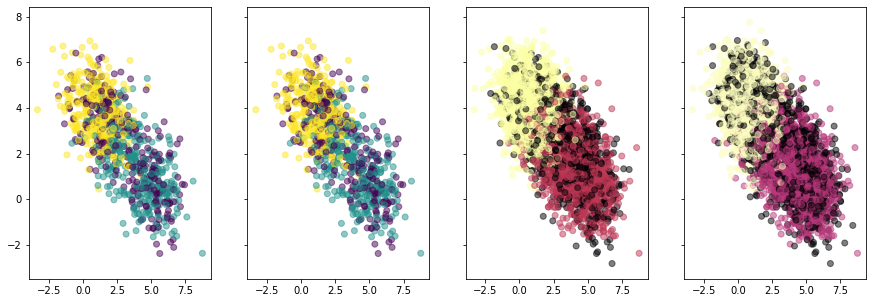

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(15,5))

ax[0].scatter(reduced_data[6],reduced_data[13],
              c=reduced_data['label'],cmap='viridis',alpha=0.5)
ax[0].set_title('reduced data')
ax[1].scatter(condensed_data[6],condensed_data[13],
              c=condensed_data['label'],cmap='viridis',alpha=0.5)
ax[1].set_title('condensed data')
ax[2].scatter(clean_data[6],clean_data[13],
              c=clean_data['label'],cmap='inferno',alpha=0.5)
ax[2].set_title('clean data')
ax[3].scatter(data[6],data[13],
              c=data[21],cmap='magma',alpha=0.5)
ax[3].set_title('original dataset')

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(clean_data[range(21)].values,clean_data['label'])
pred = knn.predict(data[range(21)].values)
print('accuracy for clean data',accuracy_score(data[21].values, pred))
print()
knn.fit(condensed_data[range(21)].values,condensed_data['label'])
pred = knn.predict(clean_data[range(21)].values)
print('accuracy for condensed data on clean data',accuracy_score(clean_data['label'].values, pred))
print()
knn.fit(reduced_data[range(21)].values,reduced_data['label'])
pred = knn.predict(clean_data[range(21)].values)
print('accuracy for reduced data on clean data',accuracy_score(clean_data['label'].values, pred))

accuracy for clean data 0.8718

accuracy for condensed data on clean data 1.0

accuracy for reduced data on clean data 1.0


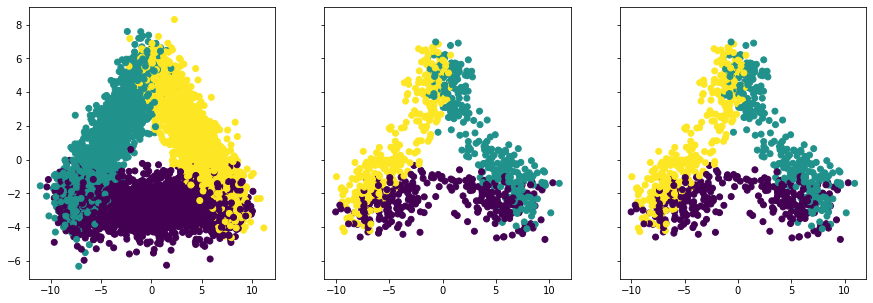

In [9]:
# performing PCA with 2 components on reduced, condensed and original dataset
fig,ax = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(15,5))

pca = PCA(n_components=2)
pcomp = pca.fit_transform(data[range(21)].values)

ax[0].scatter(pcomp[:,0],pcomp[:,1],c=data[21])

pca = PCA(n_components=2)
pcomp = pca.fit_transform(condensed_data[range(21)].values)

ax[1].scatter(pcomp[:,0],pcomp[:,1],c=condensed_data['label'])

pca = PCA(n_components=2)
pcomp = pca.fit_transform(reduced_data[range(21)].values)

ax[2].scatter(pcomp[:,0],pcomp[:,1],c=reduced_data['label'])